In [4]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
import io
import numpy as np
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
import os
%matplotlib notebook
# import mpld3
# mpld3.enable_notebook()

In [5]:
df = pd.read_csv("../dataset/erik_data/data_Erik14_C4.txt", sep=" ", header=None)
data=df.values

In [99]:
def b_b(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bf(data,  lowcut=110, highcut=250, fs=2048, order=3):
    b, a = b_b(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data.T)
    return y.T

def p3(array):
    return np.array(array)**3

def tkeo(array):
    final_array = []
    for channel_index in range(array.shape[1]):    
        my_array = []
        tmp = array[:,channel_index]
        for i in range(tmp.size):
            if i<2:
                my_array.append(tmp[i])
            else:
#                 my_array.append(tmp[i-2]*tmp[i-1]*tmp[i])
                my_array.append(tmp[i-1]*tmp[i-1] - tmp[i-2]* tmp[i])
        final_array.append(np.array(my_array))
    final_array = np.array(final_array)
    return final_array.T

def my_abs(array):
    return np.absolute(array)

def plot_data(a1,a2,lab):
    fig= plt.figure(figsize=(12,5))
    plt.plot(a1) 
    plt.plot(a2)
#     plt.plot(t_data, label='CH 1') 
#     plt.plot(data[:,4], label='Left Click From OS')
    plt.ylabel(lab)
#     plt.legend()
    plt.show()
    


In [100]:
emg_indices = np.array([0,1,2,3])
click_indices = np.array([4,5,6])
noise_window_range = [0.7500, 0.3500]
lead_window_range = [0.1000, 0.0000]
training_sample_chosen_for_classification = 0.500
sampling_rate = 2048.00
training_data = []

In [101]:
d_emg=data[:,emg_indices]
d_clicks=data[:,click_indices]

d_tkeo=tkeo(data[:,emg_indices])
d_p3_tkeo=tkeo(p3(data[:,emg_indices]))


d_f_tkeo=tkeo(bf(data[:,emg_indices]))
d_f_p3_tkeo=tkeo(p3(bf(data[:,emg_indices])))
# plot_data(d_tkeo[:,0], d_clicks[:,0],"TKEO")

<IPython.core.display.Javascript object>


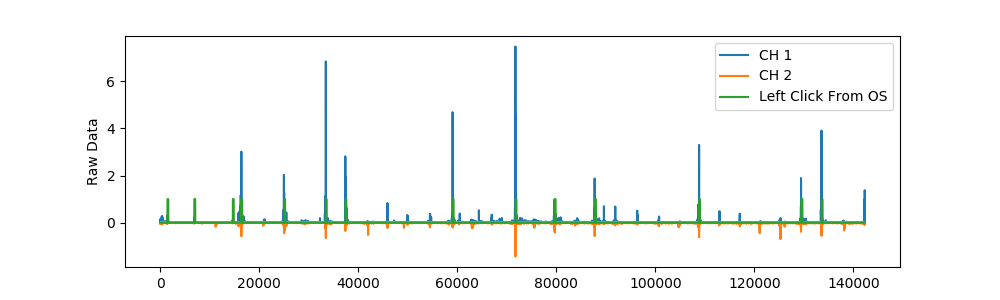

In [102]:
fig= plt.figure(figsize=(10,3))
plt.plot(my_abs(d_tkeo[:,0]), label='CH 1') 
plt.plot(-my_abs(d_tkeo[:,1]), label='CH 2') 
plt.plot(d_clicks[:,0], label='Left Click From OS')
plt.ylabel("Raw Data")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


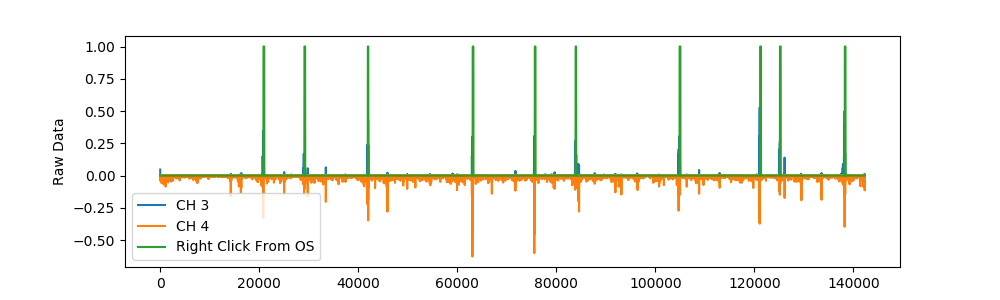

In [103]:
fig= plt.figure(figsize=(10,3))
plt.plot(my_abs(d_tkeo[:,2]), label='CH 3') 
plt.plot(-my_abs(d_tkeo[:,3]), label='CH 4') 
plt.plot(d_clicks[:,1], label='Right Click From OS')
plt.ylabel("Raw Data")
plt.legend()
plt.show()

In [136]:
def prepareTrainingData(data_signals, data_click, sign_flag):
    #Considering both the phase, taking absolute values
    if sign_flag == 0:
        data_signals = my_abs(data_signals)
        
    classification_data = []
    noise_data = []
    readNoiseWindow = True
    for i in range(len(data_click)):
        classification_data.append([0,0,0,0,i])
        noise_data.append([data_signals[i,0],data_signals[i,1],data_signals[i,2],data_signals[i,3],i])
        if readNoiseWindow:
            if data_click[i] == 1:
                readNoiseWindow = False
                # Getting window starting sample index
                lead_start_index = (int)(lead_window_range[0]*sampling_rate)
                    
                # Getting window ending sample index
                lead_end_index = (int)(lead_window_range[1]*sampling_rate)
                if(i-lead_start_index>0):
                    tmp = i-lead_start_index
                    window = []
                    mean = 0
                    rr = 0
                    while(tmp<i-lead_end_index):
                        mean = mean + my_abs(data_signals[tmp,2])+my_abs(data_signals[tmp,3])
#                         print(my_abs(data_signals[tmp,2]), "  -  ",my_abs(data_signals[tmp,3]))
                        rr = rr + 1
#                         window.append([data_signals[tmp,0],data_signals[tmp,1],data_signals[tmp,2],data_signals[tmp,3],tmp])
                        classification_data[tmp] = [data_signals[tmp,0],data_signals[tmp,1],data_signals[tmp,2],data_signals[tmp,3],tmp]
                        noise_data[tmp] = [0,0,0,0,tmp]            
                        tmp=tmp+1
#                     print(mean,"\n\n")
#                     classification_data.extend(window)
#             else:
#                 noise_data.append()
                
        elif readNoiseWindow == False:
            noise_data[i] = [0,0,0,0,i]
            if data_click[i] == 0:
                readNoiseWindow = True;
    print("classification_data shape is ",np.array(classification_data).shape)
    print("noise_data shape is ",np.array(noise_data).shape)
    print("total_samples shape is ",np.array(data_signals).shape)
    return np.array(classification_data), np.array(noise_data)
c_d, n_d = prepareTrainingData(d_tkeo, d_clicks[:,1], 0)


index = 0
while(index + 10 < d_tkeo.shape[0]):
    i=index
    mean = 0
    while(i < index + 10):
        mean = mean + my_abs(d_tkeo[i,2])+my_abs(d_tkeo[i,3])
        i=i+1
    if(mean/10 > 0.34):
        print(mean)
    index=index+1


classification_data shape is  (142320, 5)
noise_data shape is  (142320, 5)
total_samples shape is  (142320, 4)
3.4146156181398504
3.40013376407882
3.82940333168712
4.14980597308995
4.220600395770311
4.168404838949501
4.05542779986719
3.9727924624035404
3.4398669938534
3.796110964219801
4.192229129243954
4.375659742126108
4.461318109507328
4.476188433271391
3.94283118829059
3.49259153703484


<IPython.core.display.Javascript object>


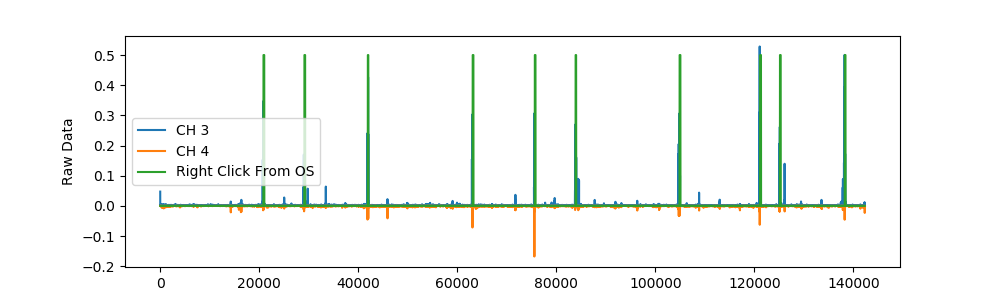

classification_data shape is  (142320, 5)
noise_data shape is  (142320, 5)
total_samples shape is  (142320, 4)


<IPython.core.display.Javascript object>


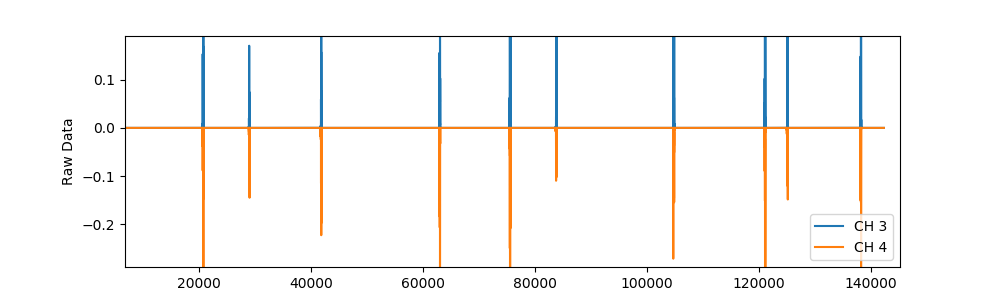

<IPython.core.display.Javascript object>


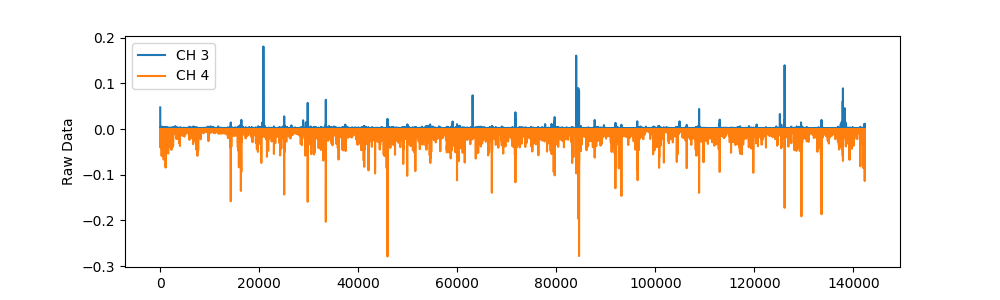

In [140]:
fig= plt.figure(figsize=(10,3))
plt.plot(my_abs(d_tkeo[:,2]), label='CH 3') 
plt.plot(-my_abs(d_f_tkeo[:,3]), label='CH 4') 
plt.plot(d_clicks[:,1]*0.5, label='Right Click From OS')
plt.ylabel("Raw Data")
plt.legend()
plt.show()

c_d, n_d = prepareTrainingData(d_tkeo, d_clicks[:,1], 0)
fig= plt.figure(figsize=(10,3))
plt.plot(my_abs(c_d[:,2]), label='CH 3') 
# plt.ylim(0.0, 0.05)
plt.plot(-my_abs(c_d[:,3]), label='CH 4') 
# plt.plot(d_clicks[:,1]*0.5, label='Right Click From OS')
plt.ylabel("Raw Data")
plt.legend()
plt.show()

fig= plt.figure(figsize=(10,3))
plt.plot(my_abs(n_d[:,2]), label='CH 3') 
plt.plot(-my_abs(n_d[:,3]), label='CH 4') 
# plt.plot(d_clicks[:,1]*0.5, label='Right Click From OS')
plt.ylabel("Raw Data")
plt.legend()
plt.show()

In [7]:
"""
Function to compute noise for 4 channels
Input 1: no_of_samples x 4 matrix(emg signal - ch1, ch2, ch3, ch4)
Input 2: no_of_samples x 3 matrix(clicks types - left, right, thumb)
Input 3: sign flag 0 for absolute value, -1 for considering negative phase(values), +1 for considering positive phase(values)

Return: Noise of four channels
"""
def computeGlobalNoise(data_signals, data_clicks, sign_flag):
    
    yo=1;
    #Considering both the phase, taking absolute values
    if sign_flag == 0:
        data_signals = my_abs(data_signals)
    
    # Iterating through to type of clicks, as data_clicks shape is: no_of_samples x 3 matrix(clicks types - left, right, thumb)
    for c in range(data_clicks.shape[1]):
        readNoiseWindow = True
        max_noise_values_of_clicks = []
        
        # Iterating through to no_of_samples as data_clicks shape is: no_of_samples x 3 matrix(clicks types - left, right, thumb)
        for i in range(data_clicks.shape[0]):
            if readNoiseWindow:
                
                # If click found as down, execute below and set startNoiseComputation to False
                if data_clicks[:,c][i] == 1:
                    readNoiseWindow = False
                    
                    # Getting window starting sample index
                    noise_start_index = (int)(noise_window_range[0]*sampling_rate)
                    
                    # Getting window ending sample index
                    noise_end_index = (int)(noise_window_range[1]*sampling_rate)
                    
                    # If window starting sample index is greater than 0, this is boundary case for first click.
                    if(i-noise_start_index>0):
                    
                        # Getting noise window for one click, window is of size 820 x 4 if noise range is [0.75. 0.35]
                        window = data_signals[i-noise_start_index:i-noise_end_index,:]
                        
                        if yo==1:
                            training_data.append([np.median(sorted(window[:,0])), np.median(sorted(window[:,1])), np.median(sorted(window[:,2])), np.median(sorted(window[:,3])), 0]) 
                            training_data.append([np.median(sorted(window[:,0])), np.median(sorted(window[:,1])), np.median(sorted(window[:,2])), np.median(sorted(window[:,3])), 0]) 
                            training_data.append([np.median(sorted(window[:,0])), np.median(sorted(window[:,1])), np.median(sorted(window[:,2])), np.median(sorted(window[:,3])), 0])   
                        
                        # Taking maximum value of the window which will be of [1 x 4]
                        # appending it to max_noise_values_of_clicks  
                        # the final shape of max_noise_values_of_clicks will be : [no_of_clicks x 1 x 4]s
                        max_noise_values_of_clicks.append(np.amax(np.array(window), axis=0))

            elif readNoiseWindow == False and data_clicks[:,c][i] == 0:
                readNoiseWindow = True;
                
        # For Left click 
        if c==0:
            yo=0;
            #Taking maximum value of all windows for left click
            left_click_noise = np.array(np.amax(np.array(max_noise_values_of_clicks), axis=0))
        
        # For Right click 
        elif c==1:
            #Taking maximum value of all windows for right click
            right_click_noise = np.array(np.amax(np.array(max_noise_values_of_clicks), axis=0))
        
        # For Thumb click 
        elif c==2:
            #Taking maximum value of all windows for thumb click
            thumb_click_noise = np.array(np.amax(np.array(max_noise_values_of_clicks), axis=0))
            
    return np.amin([left_click_noise, right_click_noise, thumb_click_noise], axis=0)

In [9]:
def getTrainingData(data_signals, data_clicks, sign_flag):
    
    #Considering both the phase, taking absolute values
    if sign_flag == 0:
        data_signals = my_abs(data_signals)
        
    # Iterating through to type of clicks, as data_clicks shape is: no_of_samples x 3 matrix(clicks types - left, right, thumb)
    for c in range(data_clicks.shape[1]):
        readTrainingWindow = True
        
        # Iterating through to no_of_samples as data_clicks shape is: no_of_samples x 3 matrix(clicks types - left, right, thumb)
        for i in range(data_clicks.shape[0]):
            if readTrainingWindow:
                
                # If click found as down, execute below and set startNoiseComputation to False
                if data_clicks[i,c] == 1.0:
                    samples_for_classification = []
                    readTrainingWindow = False
                    
                    # Getting window starting sample index
                    lead_start_index = (int)(lead_window_range[0]*sampling_rate)
                    
                    # Getting window ending sample index
                    lead_end_index = (int)(lead_window_range[1]*sampling_rate)
                    
                    # If window starting sample index is greater than 0, this is boundary case for first click.
                    if(i-lead_start_index>0):
                    
                        # Getting noise window for one click, window is of size 204 x 4 for window range is [0.1. 0.0]
                        window = data_signals[i-lead_start_index:i-lead_end_index,:]
                        
                        #
                        channel_1_values_greater_than_noise = []
                        channel_2_values_greater_than_noise = []
                        channel_3_values_greater_than_noise = []
                        channel_4_values_greater_than_noise = []
                        for row in window:
                            if row[0]>=global_noise[0]: 
                                channel_1_values_greater_than_noise.append(row[0])
                            if row[1]>=global_noise[1]: 
                                channel_2_values_greater_than_noise.append(row[1])
                            if row[2]>=global_noise[2]:
                                channel_3_values_greater_than_noise.append(row[2])
                            if row[3]>=global_noise[3]:
                                channel_4_values_greater_than_noise.append(row[3])
                       
                        v1=0.0
                        v2=0.0
                        v3=0.0
                        v4=0.0
                    
                        
                        if len(channel_1_values_greater_than_noise)>0:
                            channel_1_values_sorted = np.array(sorted(channel_1_values_greater_than_noise))
                        else:
                            channel_1_values_sorted = np.array(sorted(window[:,1]))
                        index_ch_1= int(len(channel_1_values_sorted)*training_sample_chosen_for_classification)
                        v1 = channel_1_values_sorted[index_ch_1]
                        
                        if len(channel_2_values_greater_than_noise)>0:
                            channel_2_values_sorted = np.array(sorted(channel_2_values_greater_than_noise))
                        else:
                            channel_2_values_sorted = np.array(sorted(window[:,1]))
                        index_ch_2= int(len(channel_2_values_sorted)*training_sample_chosen_for_classification)
                        v2 = channel_2_values_sorted[index_ch_2]
                        
                        if len(channel_3_values_greater_than_noise)>0:
                            channel_3_values_sorted = np.array(sorted(channel_3_values_greater_than_noise))
                        else:
                            channel_3_values_sorted = np.array(sorted(window[:,1]))
                        index_ch_3= int(len(channel_3_values_sorted)*training_sample_chosen_for_classification)
                        v3 = channel_3_values_sorted[index_ch_3]
                        
                        if len(channel_4_values_greater_than_noise)>0:
                            channel_4_values_sorted = np.array(sorted(channel_4_values_greater_than_noise))
                        else:
                            channel_4_values_sorted = np.array(sorted(window[:,1]))
                        index_ch_4= int(len(channel_4_values_sorted)*training_sample_chosen_for_classification)
                        v4 = channel_4_values_sorted[index_ch_4]
                            
                        training_data.append([v1,v2,v3,v4,c+1])
                        
            elif readTrainingWindow == False and data_clicks[i,c] == 0.0:
                readTrainingWindow = True;

#     return np.array(training_data)

# getTrainingData(d_tkeo, d_clicks, 0)

In [12]:
np.set_printoptions(edgeitems=30, linewidth=100000)
def myClassifier(train_data,test_data):
#     clf = QuadraticDiscriminantAnalysis()
#     clf = LinearDiscriminantAnalysis()
    clf = KNeighborsClassifier(n_neighbors=5)
#     clf = DecisionTreeClassifier(random_state=0)
    clf.fit(train_data[:,:4], train_data[:,4])
    pred = np.array(clf.predict(test_data))
    return pred

def ifTruePositive(loc, click_array):
    i = loc
    lead = 0
    while(i<loc+200 and i<len(click_array)):
        if click_array[i]==1:
            return True, lead/2
        i+=1
        lead+=1
    return False, lead

def showResults(d_clicks,pred):
    left_tp = []
    left_fp = 0

    right_tp = []
    right_fp = 0

    check_next_left= 0
    check_next_right= 0
    for i in range(len(pred)):

        if pred[i]==1 and i>check_next_left:
            status, lead = ifTruePositive(i, d_clicks[:,0])
            if status:
                if d_clicks[i,0]==0:
                    left_tp.append(lead);
            else:
                left_fp+=1
            check_next_left = i + 200

        if pred[i]==2 and i>check_next_right:
            status, lead = ifTruePositive(i, d_clicks[:,1])
            if status:
                if d_clicks[i,1]==0:
                    right_tp.append(lead);
            else:
                right_fp+=1
            check_next_right = i + 200    

    print("Left TP ", len(left_tp), " ", left_tp)
    print("Left FP ", left_fp)
    print("Right TP ", len(right_tp)," ",right_tp)
    print("Right FP ", right_fp)

In [15]:
print("\n\nTKEO")
training_data = []
global_noise = computeGlobalNoise(d_tkeo, d_clicks, 0)
print(global_noise)
print(training_data)
getTrainingData(d_tkeo, d_clicks, 0)
pred = myClassifier(np.array(training_data),d_tkeo)
# showResults(d_clicks,pred)



TKEO
[0.00443912 0.00510299 0.00033812 0.00931804]
[[3.299627117963114e-05, 9.467243304234663e-05, 1.536035795695265e-05, 1.5619770556500088e-06, 0], [3.299627117963114e-05, 9.467243304234663e-05, 1.536035795695265e-05, 1.5619770556500088e-06, 0], [3.299627117963114e-05, 9.467243304234663e-05, 1.536035795695265e-05, 1.5619770556500088e-06, 0], [2.5972418879426528e-05, 5.63206901299057e-05, 9.160051871714118e-06, 2.425111709269954e-06, 0], [2.5972418879426528e-05, 5.63206901299057e-05, 9.160051871714118e-06, 2.425111709269954e-06, 0], [2.5972418879426528e-05, 5.63206901299057e-05, 9.160051871714118e-06, 2.425111709269954e-06, 0], [4.0566729993826215e-05, 8.009955154469068e-05, 1.1076472276708328e-05, 2.128867482330707e-06, 0], [4.0566729993826215e-05, 8.009955154469068e-05, 1.1076472276708328e-05, 2.128867482330707e-06, 0], [4.0566729993826215e-05, 8.009955154469068e-05, 1.1076472276708328e-05, 2.128867482330707e-06, 0], [2.4968646323693664e-05, 8.89047648836195e-05, 8.323812234683373

In [13]:
print("\n\nTKEO")
training_data = []
global_noise = computeGlobalNoise(d_tkeo, d_clicks, 0)
getTrainingData(d_tkeo, d_clicks, 0)
pred = myClassifier(np.array(training_data),d_tkeo)
showResults(d_clicks,pred)


print("\n\nF-TKEO")
training_data = []
global_noise = computeGlobalNoise(d_f_tkeo, d_clicks, 0)
getTrainingData(d_f_tkeo, d_clicks, 0)
pred = myClassifier(np.array(training_data),d_f_tkeo)
showResults(d_clicks,pred)


print("\n\nP3-TKEO")
training_data = []
global_noise = computeGlobalNoise(d_p3_tkeo, d_clicks, 0)
getTrainingData(d_p3_tkeo, d_clicks, 0)
pred = myClassifier(np.array(training_data),d_p3_tkeo)
showResults(d_clicks,pred)


print("\n\nF-P3-TKEO")
training_data = []
global_noise = computeGlobalNoise(d_f_p3_tkeo, d_clicks, 0)
getTrainingData(d_f_p3_tkeo, d_clicks, 0)
pred = myClassifier(np.array(training_data),d_f_p3_tkeo)
showResults(d_clicks,pred)




# computeGlobalNoise(d_p3_tkeo, d_clicks, 0)
# computeGlobalNoise(d_f_tkeo, d_clicks, 0)
# computeGlobalNoise(d_f_p3_tkeo, d_clicks, 0)  



TKEO
Left TP  13   [24.5, 22.0, 50.0, 60.0, 96.0, 35.5, 99.0, 92.0, 73.0, 67.5, 55.0, 49.5, 87.5]
Left FP  76
Right TP  10   [30.0, 66.0, 51.0, 17.0, 59.0, 15.5, 93.5, 66.0, 22.0, 60.5]
Right FP  22


F-TKEO
Left TP  11   [66.0, 42.0, 90.0, 19.0, 26.5, 56.0, 61.0, 60.5, 48.5, 43.0, 80.5]
Left FP  27
Right TP  10   [27.5, 60.5, 45.0, 28.0, 54.0, 37.5, 89.0, 64.5, 55.5, 59.5]
Right FP  25


P3-TKEO
Left TP  13   [21.0, 18.5, 39.0, 59.0, 96.0, 19.5, 88.5, 91.5, 73.0, 66.5, 55.0, 49.5, 87.5]
Left FP  47
Right TP  8   [27.5, 51.0, 32.5, 59.0, 82.0, 65.5, 6.0, 28.0]
Right FP  19


F-P3-TKEO
Left TP  11   [65.5, 42.0, 90.0, 14.0, 26.5, 55.5, 61.0, 60.5, 48.5, 43.0, 80.5]
Left FP  26
Right TP  10   [27.5, 61.0, 45.0, 27.5, 54.0, 37.0, 89.0, 64.5, 55.0, 23.0]
Right FP  56
